In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import joblib
from typing import List, Dict


/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all')

import re

def clean_text(text):
    # Remove escape sequences
    text = re.sub(r'\\[a-zA-Z]', ' ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Example usage:
text = "Hello, this is an example text with an email address john@example.com. \nPlease remove punctuation and escape sequences, including \\n."
cleaned_text = clean_text(text)
print(cleaned_text)


from tqdm import tqdm

docs = []
for text in tqdm(newsgroups_train["data"]):
  docs.append(clean_text(text))

Hello this is an example text with an email address Please remove punctuation and escape sequences including


100%|██████████| 18846/18846 [00:01<00:00, 12488.91it/s]


In [3]:
docs = []
count = 0
for text in tqdm(newsgroups_train["data"]):
  count+=1
  docs.append(clean_text(text) + f" c_{count}")


100%|██████████| 18846/18846 [00:01<00:00, 11868.91it/s]


In [10]:
topic_model = BERTopic(top_n_words=50)
topics, probs = topic_model.fit_transform(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [17]:
topic_model.get_topic(1)[-5:] 

[('that', 0.0033241829029214093),
 ('out', 0.0033219513666885173),
 ('median', 0.00328452812060401),
 ('molestation', 0.0032549704432380455),
 ('your', 0.0032432597073893147)]

# LDA Checkup

In [2]:
import json 
import ast
import numpy as np
import scipy
    
def percent_document_change_lda(path,total_topics,intervals):

    result = {}
    for k in intervals: 
        result[k] = []

    
    # open comparison_result.json to get data about topic change
    f = open(path)
    data = json.load(f)

    representation_word_list = {}
    for topic_i in range(1,total_topics):
        representation_word_list[topic_i] = data[str(topic_i)].keys()


    # for each topic loop over
    for topic_i in range(1,total_topics):
        top_rep_wl = list(representation_word_list[topic_i])
        doc_count = data[f"{topic_i}"][top_rep_wl[0]]["topic_change"] + data[f"{topic_i}"][top_rep_wl[0]]["topic_same"]
        if "" not in top_rep_wl and doc_count != 0:
            topic_data = data[f"{topic_i}"]
            topic_change = []
            # for each word in the topic
            for word in top_rep_wl:
                # print(topic_data.keys())
                topic_change.append(topic_data[word]["topic_change"])
                
            for k in intervals: # 
                result[k].append(sum(topic_change[:k])/doc_count)

    for key in result.keys():
        result[key] = np.mean(result[key])
    return result

def normalize(x):
    if sum(x) == 0 :
        return [val + 0.5 for val in x]
    elif max(x) == min(x):
        # Handle the case where all elements are the same
        return [0] * len(x)
    else:
        x_ = []
        for i in x:
            x_.append((i - min(x)) / (max(x) - min(x)))
        return x_

def create_overall_stats_lda(path_to_base:str,path_to_topic_change:str,k:int,choice,top_k:int = 10):
    f = open(path_to_base)
    base_data = json.load(f)
    correlations_,p_values = [],[]

    # Step 1: Load DataFrame from CSV
    f = open(path_to_topic_change)
    tc_data = json.load(f)



    for topic_i in range(1,k):
        x,y = [],[]
        for word in tc_data[str(topic_i)]:
            word_score = tc_data[str(topic_i)][word][choice]
            word_base_score = base_data[str(topic_i)][word]

            x.append(word_base_score) # lda rankings
            y.append(word_score) # topic_change rankings
        
        x,y = normalize(x),normalize(y)

        rho, p_value = scipy.stats.kendalltau(x[:top_k], y[:top_k])
        correlations_.append(rho)
        p_values.append(p_value)
    return (correlations_,p_values)

def remove_nan_entries(list1, list2):
    # Find indices where the first list has nan values
    nan_indices = np.isnan(list1)

    # Use boolean indexing to filter out nan entries from both lists
    filtered_list1 = [val for i, val in enumerate(list1) if not nan_indices[i]]
    filtered_list2 = [val for i, val in enumerate(list2) if not nan_indices[i]]

    return filtered_list1, filtered_list2

def correlation_stats(correlations, p_values):
    overall_corr_avg = np.mean(correlations)
    overall_corr_std = np.std(correlations)
    overall_p_val_avg = sum(p_values) / len(p_values)

    filtered_data = [(corr, p_val) for corr, p_val in zip(correlations, p_values) if p_val > 0.4]
    filtered_corr_avg = sum(corr for corr, _ in filtered_data) / len(filtered_data) if filtered_data else None
    filtered_p_val_avg = sum(p_val for _, p_val in filtered_data) / len(filtered_data) if filtered_data else None

    return {
        'overall_corr_avg': overall_corr_avg,
        'overall_corr_std' : overall_corr_std,
        'overall_p_val_avg': overall_p_val_avg,
        'filtered_corr_avg': filtered_corr_avg,
        'filtered_p_val_avg': filtered_p_val_avg
    }

def save_list_to_text_file(lst, file_path):
    with open(file_path, 'w') as f:
        for item in lst:
            f.write(str(item) + '\n')
            
def lda_corr(path_base,path_tc,k,choice,topk):
    c,p = create_overall_stats_lda(path_base,path_tc,k,choice,topk)
    c,p = remove_nan_entries(c,p)
    save_list_to_text_file(c,"/".join(path_base.split("/")[:-1])+"/correlations.txt")
    corr = correlation_stats(c,p)
    print(corr)

In [3]:
lda_corr("result_2/comprehensiveness/20newsgroup/lda_model/lda_20ng_base.json","result_2/comprehensiveness/20newsgroup/lda_model/lda_20ng.json",100,"topic_change",10)
percent_document_change_lda("result_2/comprehensiveness/20newsgroup/lda_model/lda_20ng.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.2377023222299654, 'overall_corr_std': 0.2831301948528202, 'overall_p_val_avg': 0.32723956249242914, 'filtered_corr_avg': 0.05289701533324798, 'filtered_p_val_avg': 0.6561631521716178}


{5: 0.2794440848747526, 7: 0.3489178666844416, 10: 0.45346408383489817}

In [4]:
lda_corr("result/comprehensiveness/nyt/lda_model/lda_nyt_base.json","result/comprehensiveness/nyt/lda_model/lda_nyt.json",100,"topic_change",10)
percent_document_change_lda("result/comprehensiveness/nyt/lda_model/lda_nyt.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.3633378964959947, 'overall_corr_std': 0.23768859282232221, 'overall_p_val_avg': 0.23478948530564678, 'filtered_corr_avg': 0.07484331933340346, 'filtered_p_val_avg': 0.609086233295627}


{5: 0.31207235366803265, 7: 0.38146004369606185, 10: 0.4606390406717747}

In [6]:
lda_corr("result/comprehensiveness/wiki/lda_model/lda_wiki_base.json","result/comprehensiveness/wiki/lda_model/lda_wiki.json",100,"topic_change",10)
percent_document_change_lda("result/comprehensiveness/wiki/lda_model/lda_wiki.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.1888335495361466, 'overall_corr_std': 0.29235266296844326, 'overall_p_val_avg': 0.38760891263834424, 'filtered_corr_avg': 0.04234043868968326, 'filtered_p_val_avg': 0.675530214948727}


{5: 0.0707054402125206, 7: 0.09925405508030968, 10: 0.12106287402668757}

## sufficiency correlations

In [7]:
lda_corr("result/sufficiency/20newsgroup/lda_model/lda_20ng_base.json","result/sufficiency/20newsgroup/lda_model/lda_20ng.json",100,"topic_same",10)
percent_document_change_lda("result/sufficiency/20newsgroup/lda_model/lda_20ng.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.1377048288836623, 'overall_corr_std': 0.2952309492784972, 'overall_p_val_avg': 0.42406814977784724, 'filtered_corr_avg': 0.015278133854273136, 'filtered_p_val_avg': 0.7176789152730535}


{5: 4.467295858940059, 7: 6.3177631492339765, 10: 9.077762872953413}

In [8]:
lda_corr("result/sufficiency/nyt/lda_model/lda_nyt_base.json","result/sufficiency/nyt/lda_model/lda_nyt.json",100,"topic_same",10)
percent_document_change_lda("result/sufficiency/nyt/lda_model/lda_nyt.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.33936145502152865, 'overall_corr_std': 0.25246707052724704, 'overall_p_val_avg': 0.28372361502064786, 'filtered_corr_avg': 0.08824217232992757, 'filtered_p_val_avg': 0.7008238068771329}


{5: 4.662335970519146, 7: 6.591830535767445, 10: 9.510600494692662}

In [9]:
lda_corr("result/sufficiency/wiki/lda_model/lda_wiki_base.json","result/sufficiency/wiki/lda_model/lda_wiki.json",100,"topic_same",10)
percent_document_change_lda("result/sufficiency/wiki/lda_model/lda_wiki.json",total_topics=100,intervals=[5,7,10])

{'overall_corr_avg': 0.11156391096845225, 'overall_corr_std': 0.2765809635927277, 'overall_p_val_avg': 0.418401777953988, 'filtered_corr_avg': 0.03374762954530521, 'filtered_p_val_avg': 0.635244953597585}


{5: 3.9111854078783783, 7: 5.509872341469279, 10: 8.037256628139117}

# Box plots

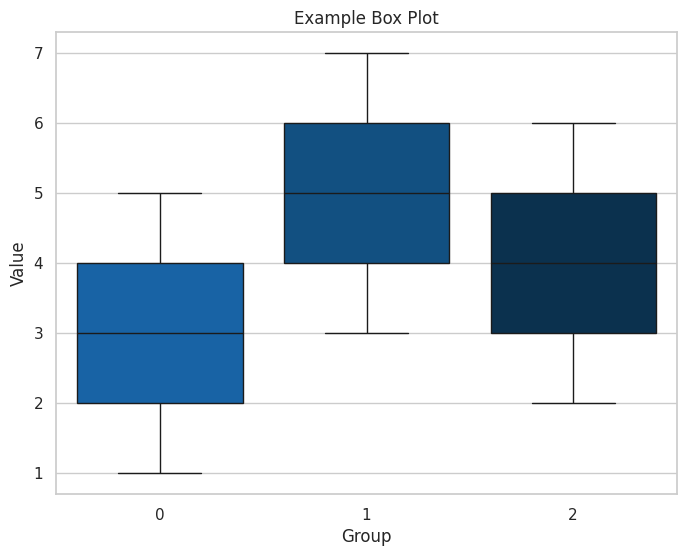

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_box_plot(data, title='Box Plot', xlabel='X Axis', ylabel='Y Axis'):
    custom_palette = sns.color_palette([(0/255, 101/255, 189/255), (0/255, 82/255, 147/255), (0/255, 51/255, 89/255)])
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, palette=custom_palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Example usage:
data = [[1, 2, 3, 4, 5], [3, 4, 5, 6, 7], [2, 3, 4, 5, 6]]
create_box_plot(data, title='Example Box Plot', xlabel='Group', ylabel='Value')


In [65]:
data_20ng = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/20newsgroup/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/20newsgroup/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/20newsgroup/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/20newsgroup/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/20newsgroup/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result_2/comprehensiveness/20newsgroup/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

In [3]:
def create_box_plot_from_files(data, title='', xlabel='Models', ylabel='Correlations'):
    # Initialize an empty list to store data from files
    all_data = []

    # Loop through each dictionary in the input data list
    for entry in data:
        # Read numbers from the file indicated by 'path' key
        with open(entry['path'], 'r') as file:
            numbers = [float(line.strip()) for line in file]
        
        # Append the numbers to the list along with the label
        all_data.append((entry['label'], numbers))

    # Define custom color palette
    custom_palette = [(152/255, 198/255, 234/255), (100/255, 160/255, 200/255),(0/255, 101/255, 189/255),  (0/255, 82/255, 147/255), (0/255, 51/255, 89/255) , (227/255, 114/255, 34/255)]

    # Create the box plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[data for _, data in all_data], palette=custom_palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(data)), [label for label, _ in all_data], rotation=45)
    plt.show()

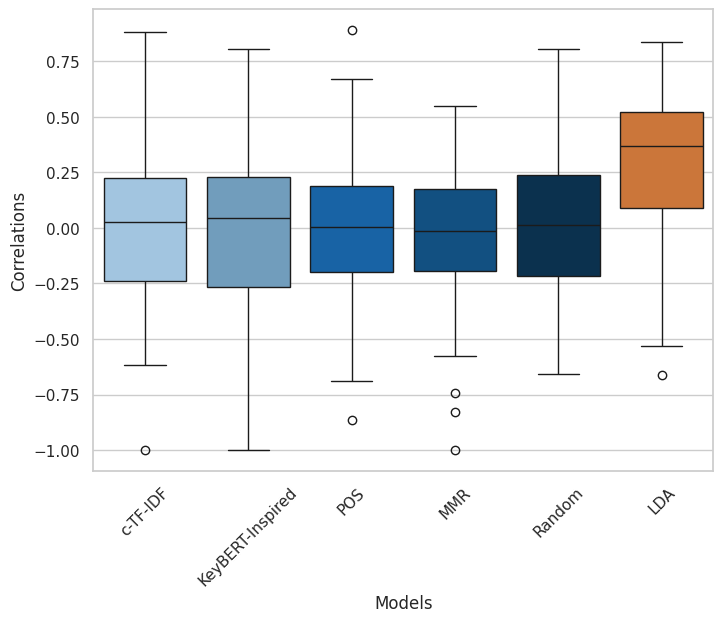

In [67]:
create_box_plot_from_files(data)

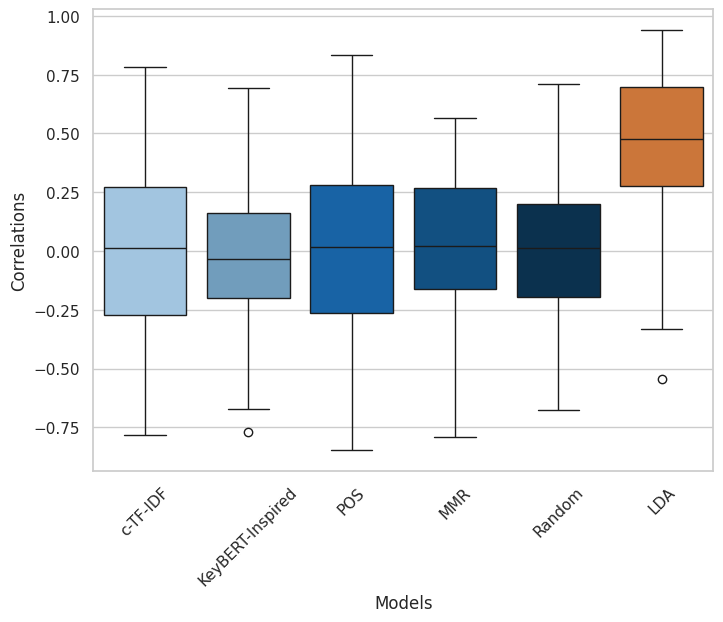

In [71]:
data_nyt = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/nyt/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/nyt/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/nyt/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/nyt/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result_2/comprehensiveness/nyt/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/nyt/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

create_box_plot_from_files(data_nyt)

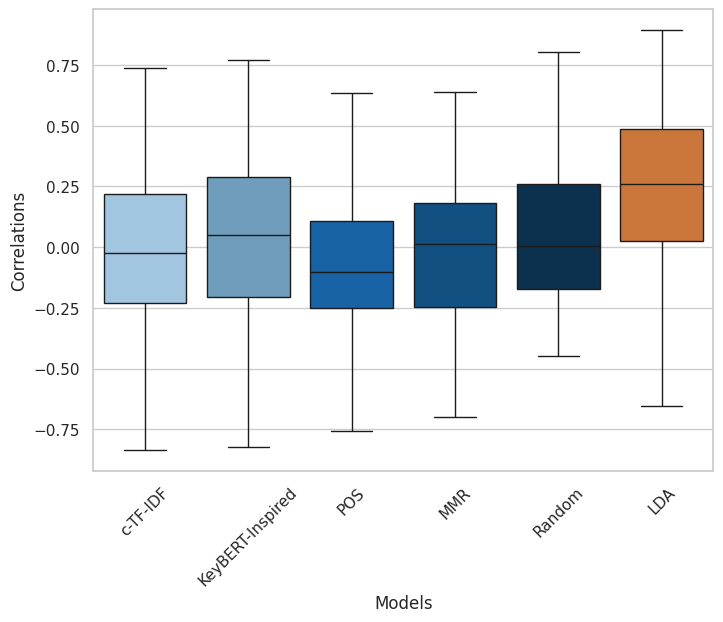

In [72]:
data_wiki = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/wiki/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/wiki/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/wiki/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/wiki/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result_2/comprehensiveness/wiki/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/comprehensiveness/wiki/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

create_box_plot_from_files(data_wiki)

# Sufficiency

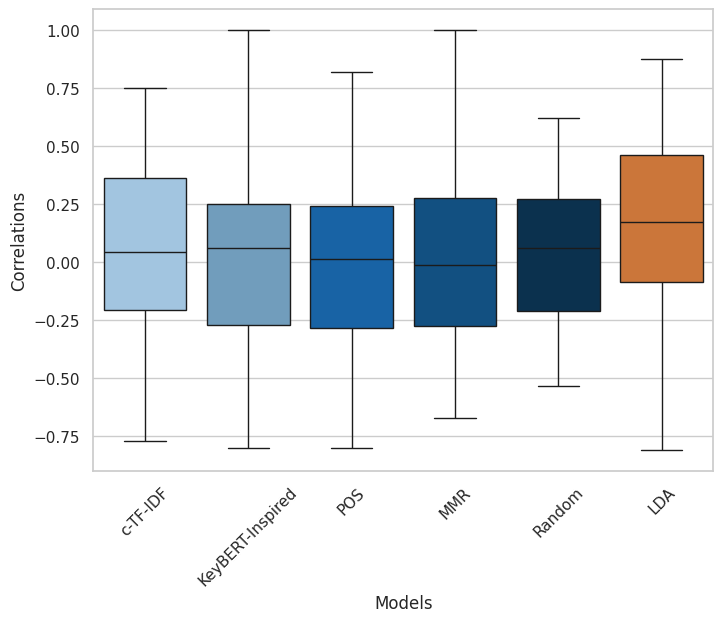

In [13]:
data_20newsgroup = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/20newsgroup/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

create_box_plot_from_files(data_20newsgroup)

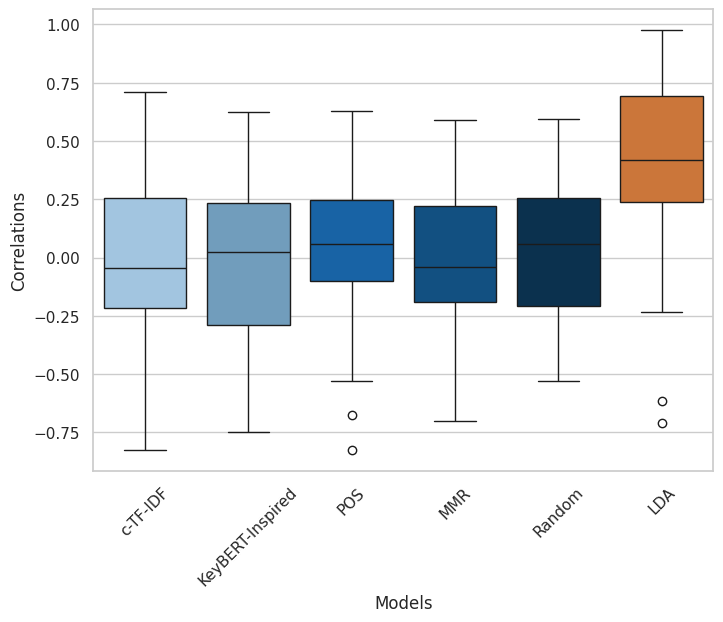

In [5]:
data_nyt = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/nyt/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/nyt/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/nyt/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/nyt/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result_2/sufficiency/nyt/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/nyt/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

create_box_plot_from_files(data_nyt)

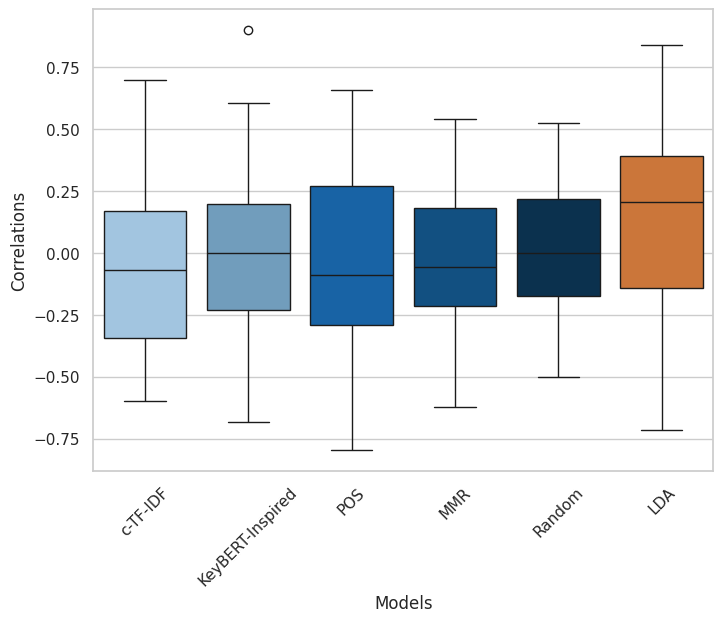

In [6]:
data_wiki = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/wiki/model_1/correlations.txt",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/wiki/model_2/correlations.txt",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/wiki/model_3/correlations.txt",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/wiki/model_4/correlations.txt",
        "label" : "MMR"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result_2/sufficiency/wiki/randomization/correlations.txt",
        "label" : "Random"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/result/sufficiency/wiki/lda_model/correlations.txt",
        "label" : "LDA"
    },
]

create_box_plot_from_files(data_wiki)

# Centroid

In [6]:
def create_box_plot_from_files(data, title='', xlabel='Models', ylabel='Correlations'):
    # Initialize an empty list to store data from files
    all_data = []

    # Loop through each dictionary in the input data list
    for entry in data:
        # Read numbers from the file indicated by 'path' key
        numbers = extract_first_numbers(entry['path'])
        
        # Append the numbers to the list along with the label
        all_data.append((entry['label'], numbers))

    # Define custom color palette
    custom_palette = [(152/255, 198/255, 234/255), (100/255, 160/255, 200/255),(0/255, 101/255, 189/255),  (0/255, 82/255, 147/255), (0/255, 51/255, 89/255) , (227/255, 114/255, 34/255)]

    # Create the box plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[data for _, data in all_data], palette=custom_palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(data)), [label for label, _ in all_data], rotation=45)
    plt.show()

import json

def extract_first_numbers(json_data):
    with open(json_data,"r") as js:
        json_data=json.load(js)
    first_numbers = []
    for key, value in json_data.items():
        for inner_key, inner_value in value.items():
            if isinstance(inner_value, list) and len(inner_value) > 0:
                first_numbers.append(inner_value[0])
    return first_numbers

/tmp/ipykernel_1822845/191235247.py:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=[data for _, data in all_data], palette=custom_palette)


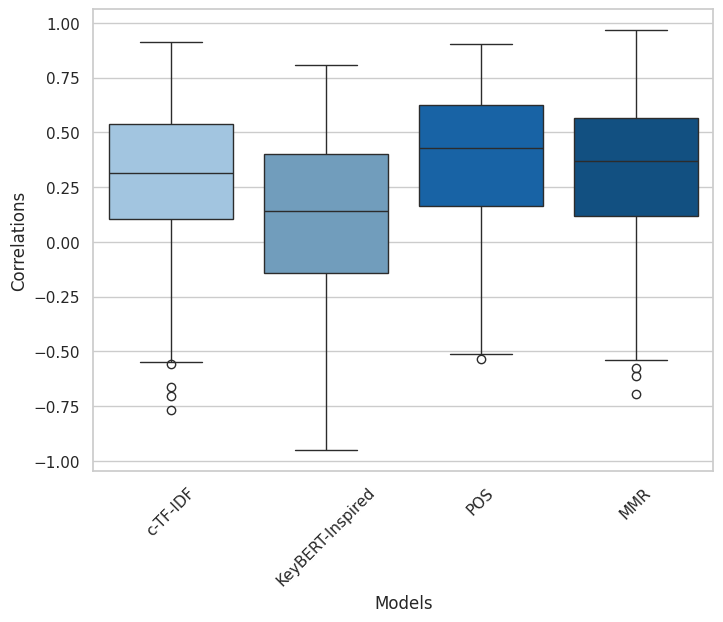

In [9]:
data_centroid = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_1.json",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_2.json",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result/centroid/centroid_3.json",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result/centroid/centroid_4.json",
        "label" : "MMR"
    },
]

create_box_plot_from_files(data_centroid)

In [ ]:
data_centroid = [
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_1.json",
        "label" : "c-TF-IDF"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_2.json",
        "label" : "KeyBERT-Inspired"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_3.json",
        "label" : "POS"
    },
    {
        "path" : "/home/abpal/WorkFiles/Faithful-Topic-Modeling/final_result_kendall/centroid/centroid_4.json",
        "label" : "MMR"
    },
]

create_box_plot_from_files(data_centroid)